![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# PCA - Tarefa 01: *HAR* com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [6]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from zenmapGUI.Icons import file_path

In [7]:
filename_features = "~/Desktop/UCI HAR Dataset/features.txt"
filename_labels = "~/Desktop/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "~/Desktop/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "~/Desktop/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "~/Desktop/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "~/Desktop/UCI HAR Dataset/test/subject_test.txt"
filename_xtest = "~/Desktop/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "~/Desktop/UCI HAR Dataset/test/y_test.txt"

# Fix: Removed 'squeeze' and converted to a Series explicitly if needed
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")['nome_var']
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])['subject_id']

X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])

X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

print(features.head())
print(labels.head())
print(subject_train.head())
print(X_train.head())
print(y_train.head())
print(subject_test.head())
print(X_test.head())
print(y_test.head())


/tmp/ipykernel_25335/3591160637.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
/tmp/ipykernel_25335/3591160637.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())


0    1 tBodyAcc-mean()-X
1    2 tBodyAcc-mean()-Y
2    3 tBodyAcc-mean()-Z
3     4 tBodyAcc-std()-X
4     5 tBodyAcc-std()-Y
Name: nome_var, dtype: object
   cod_label               label
0          1             WALKING
1          2    WALKING_UPSTAIRS
2          3  WALKING_DOWNSTAIRS
3          4             SITTING
4          5            STANDING
0    1
1    1
2    1
3    1
4    1
Name: subject_id, dtype: int64
   1 tBodyAcc-mean()-X  2 tBodyAcc-mean()-Y  3 tBodyAcc-mean()-Z  \
0             0.288585            -0.020294            -0.132905   
1             0.278419            -0.016411            -0.123520   
2             0.279653            -0.019467            -0.113462   
3             0.279174            -0.026201            -0.123283   
4             0.276629            -0.016570            -0.115362   

   4 tBodyAcc-std()-X  5 tBodyAcc-std()-Y  6 tBodyAcc-std()-Z  \
0           -0.995279           -0.983111           -0.913526   
1           -0.998245           -0.975300 

/tmp/ipykernel_25335/3591160637.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())


## Árvore de decisão

Rode uma árvore de decisão com todas as variáveis, utilizando o ```ccp_alpha=0.001```. Avalie a acurácia nas bases de treinamento e teste. Avalie o tempo de processamento.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Caminho para y_train e y_test
filename_xtrain = "~/Desktop/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "~/Desktop/UCI HAR Dataset/train/y_train.txt"

# Carregar os labels
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

# Instanciar e treinar o modelo
clf = DecisionTreeClassifier(min_samples_leaf=20)
clf.fit(X_train, y_train)

# Avaliar o modelo
train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_train, clf.predict(X_train))

print("Acuracia - treino:", train_accuracy)


/tmp/ipykernel_25335/3026601081.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())


Acuracia - treino: 0.9579706202393906


## Árvore com PCA

Faça uma análise de componemtes principais das variáveis originais. Utilize apenas uma componente. Faça uma árvore de decisão com esta componente como variável explicativa.

- Avalie a acurácia nas bases de treinamento e teste
- Avalie o tempo de processamento

In [53]:
%%time
prcomp = PCA(n_components=1).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_valida = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_treino.shape

CPU times: user 814 ms, sys: 1.78 ms, total: 816 ms
Wall time: 59.8 ms


(7352, 1)

In [56]:
%%time

clf = DecisionTreeClassifier(random_state=1234).fit(X_train, y_train)
caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    clfs.append(clf)

CPU times: user 3min 52s, sys: 1.12 ms, total: 3min 52s
Wall time: 3min 52s


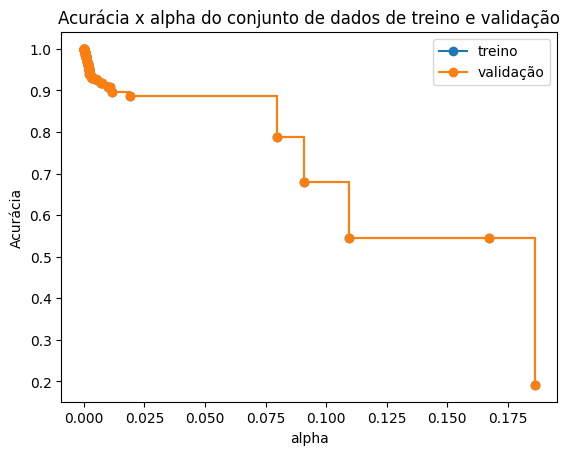

In [58]:
import matplotlib.pyplot as plt
train_scores = [clf.score(X_train, y_train) for clf in clfs]
valid_scores = [clf.score(X_train, y_train) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e validação")
ax.plot(ccp_alphas, train_scores, marker='o', label="treino", drawstyle="steps-post")
ax.plot(ccp_alphas, valid_scores, marker='o', label="validação", drawstyle="steps-post")
ax.legend()
plt.show()

In [59]:
%%time
prcomp = PCA(n_components=1).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_valida = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_treino.shape

CPU times: user 2.38 s, sys: 2.96 ms, total: 2.38 s
Wall time: 178 ms


(7352, 1)

## Testando o número de componentes

Com base no código acima, teste a árvore de classificação com pelo menos as seguintes possibilidades de quantidades de componentes: ```[1, 2, 5, 10, 50]```. Avalie para cada uma delas:

- Acurácia nas bases de treino e teste
- Tempo de processamento

In [64]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time

# Padronizar as variáveis explicativas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lista de componentes principais e inicialização de resultados
n_components = [1, 2, 5, 10, 50]
results = {"n_components": [], "train_accuracy": [], "test_accuracy": [], "time_pca": [], "time_tree": []}

for n in n_components:
    # Medir o tempo de aplicação do PCA
    start_pca = time.time()
    pca = PCA(n_components=n).fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    time_pca = time.time() - start_pca

    # Medir o tempo de treinamento da árvore de decisão
    start_tree = time.time()
    clf = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001)
    clf.fit(X_train_pca, y_train)
    time_tree = time.time() - start_tree

    # Avaliar a acurácia
    train_accuracy = accuracy_score(y_train, clf.predict(X_train_pca))
    test_accuracy = accuracy_score(y_test, clf.predict(X_test_pca))

    # Salvar os resultados
    results["n_components"].append(n)
    results["train_accuracy"].append(train_accuracy)
    results["test_accuracy"].append(test_accuracy)
    results["time_pca"].append(time_pca)
    results["time_tree"].append(time_tree)

# Exibir os resultados em um DataFrame
results_df = pd.DataFrame(results)
print(results_df)


   n_components  train_accuracy  test_accuracy  time_pca  time_tree
0             1        0.477149       0.431625  0.069452   0.044810
1             2        0.590180       0.546318  0.054413   0.036121
2             5        0.832699       0.770614  0.049273   0.046005
3            10        0.858678       0.767221  0.040839   0.086426
4            50        0.888194       0.775365  0.039074   0.394551


## Conclua

- O que aconteceu com a acurácia?
- O que aconteceu com o tempo de processamento?

In [ ]:
# questao 1

#o modelo de acuracia acima teve uma melhora de 47% do modelo treino
#ja no modelo test teve uma acuracia ainda um pouco melhor de 43%


In [ ]:
# questao 2

# em relacao ao tempo teve uma demora no de treino
# teve uma demora de quase 3 minutos